In this notebook, we study the extent to which the decision to "stop and frisk" by NYPD officers follows formal non-discrimination criteria.  

In [1082]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.linear_model import SGDClassifier


In [1083]:
def plot_by_precinct(bl_data, wh_data, title, ylabel):
    N = len(df_2020['STOP_LOCATION_PRECINCT'].unique())
        
    blue_bar = bl_data
    orange_bar = wh_data
    
    ind = np.arange(N)
    fig = plt.figure(figsize=(20,3))
    width = 0.3   
    plt.bar(ind, blue_bar , width, label='Black suspects', align='edge')
    plt.bar(ind + width, orange_bar, width, label='White suspects', align='edge')
    plt.xlabel('Precinct', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
#     plt.ylim(0, .00625)
    plt.title(title, fontsize=18)
    plt.xticks(ind + width / 2, np.sort(df_2020['STOP_LOCATION_PRECINCT'].unique()), rotation=90)
    plt.legend(loc='best')
    plt.show()

Load the data

In [1084]:
sqf2020 = pd.read_csv('data/sqf2020.csv')

In [1085]:
census_precincts = pd.read_csv('data/nyc_2010pop_2020precincts.csv')

We will assess fairness by examining stops made by the NYPD given suspicion of "criminal possession of a weapon". 

In [1086]:
sqf2020 = sqf2020[sqf2020['SUSPECTED_CRIME_DESCRIPTION'] == 'CPW']

Clean data

In [1087]:
#drop datapoints containing null or empty strings
sqf2020.drop(index=sqf2020[sqf2020['SUSPECT_REPORTED_AGE'] == ' '].index, inplace=True)

We will use $Y$ to denote the random variable that a given stopped suspect actually has a weapon ($Y=1$) or not ($Y=0$). 

We will use $\hat{Y}(X)$ to denote the decision to stop, frisk, and/or search, with the assumption that this is based on features $X$ of the suspect. 

$\hat{Y}(X) = 1$ indicates a stop, frisk, and/or search, and $\hat{Y}(X) = 0$ means no frisk and/or search was conducted after the initial stop.

The quantity we are interested in is the FPR of the implied classifier implmented by NYPD officers, $P(\hat{Y}=1 | Y = 0)$.

In particular, we are interested in how much the FPR changes when conditioning on members of groups $A$, which encodes the race of the suspect. Here, we consider the disparity between the FPR for Black and White suspects, as well as the dependence on location by precinct.

In [1092]:
#black suspects with no weapon
bl_nw = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'BLACK') 
                & (sqf2020['WEAPON_FOUND_FLAG'] == 'N')]

#black suspects with no weapon who were frisked and/or searched
bl_nw_f = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'BLACK') 
                  & (sqf2020['WEAPON_FOUND_FLAG'] == 'N') 
                  & ((sqf2020['FRISKED_FLAG'] == 'Y') | (sqf2020['SEARCHED_FLAG'] == 'Y'))]

bl_nypd_fpr = len(bl_nw_f)/len(bl_nw)

#white suspects with no weapon
wh_nw = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'WHITE') 
                & (sqf2020['WEAPON_FOUND_FLAG'] == 'N')]

wh_nw_f = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'WHITE') 
                & (sqf2020['WEAPON_FOUND_FLAG'] == 'N')
                & ((sqf2020['FRISKED_FLAG'] == 'Y') | (sqf2020['SEARCHED_FLAG'] == 'Y'))]

wh_nypd_fpr = len(wh_nw_f)/len(wh_nw)

In [1094]:
print('Probability of frisk/search for Black suspects who do not have a weapon: {}'.format(bl_nypd_fpr))
print('Probability of frisk/search for White suspects who do not have a weapon: {}'.format(wh_nypd_fpr))

Probability of frisk/search for Black suspects who do not have a weapon: 0.9089253187613844
Probability of frisk/search for White suspects who do not have a weapon: 0.8641975308641975


We also look at the TPR conditional on A.

In [1095]:
#black suspects with weapon
bl_w = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'BLACK') 
                & (sqf2020['WEAPON_FOUND_FLAG'] == 'Y')]

#black suspects with weapon who were frisked and/or searched
bl_w_f = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'BLACK') 
                  & (sqf2020['WEAPON_FOUND_FLAG'] == 'Y') 
                  & ((sqf2020['FRISKED_FLAG'] == 'Y') | (sqf2020['SEARCHED_FLAG'] == 'Y'))]

bl_nypd_tpr = len(bl_w_f)/len(bl_w)

#white suspects with weapon
wh_w = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'WHITE') 
                & (sqf2020['WEAPON_FOUND_FLAG'] == 'Y')]

wh_w_f = sqf2020[(sqf2020['SUSPECT_RACE_DESCRIPTION'] == 'WHITE') 
                & (sqf2020['WEAPON_FOUND_FLAG'] == 'Y')
                & ((sqf2020['FRISKED_FLAG'] == 'Y') | (sqf2020['SEARCHED_FLAG'] == 'Y'))]

wh_nypd_tpr = len(wh_w_f)/len(wh_w)


In [1096]:
print('Probability of frisk/search for Black suspects who have a weapon: {}'.format(bl_nypd_tpr))
print('Probability of frisk/search for White suspects who have a weapon: {}'.format(wh_nypd_tpr))

Probability of frisk/search for Black suspects who have a weapon: 0.9560723514211886
Probability of frisk/search for White suspects who have a weapon: 0.9473684210526315


In [1097]:
bl_fpr_by_precinct = []
bl_fpcounts_by_precinct = []
wh_fpr_by_precinct = [] 
wh_fpcounts_by_precinct = []
for precinct in np.sort(sqf2020['STOP_LOCATION_PRECINCT'].unique()):
    precinct_df = sqf2020[sqf2020['STOP_LOCATION_PRECINCT'] == precinct]
    #black suspects with no weapon
    bl_nw = precinct_df[(precinct_df['SUSPECT_RACE_DESCRIPTION'] == 'BLACK') 
                & (precinct_df['WEAPON_FOUND_FLAG'] == 'N')]

    #black suspects with no weapon who were frisked and/or searched
    bl_nw_f = precinct_df[(precinct_df['SUSPECT_RACE_DESCRIPTION'] == 'BLACK') 
                  & (precinct_df['WEAPON_FOUND_FLAG'] == 'N') 
                  & ((precinct_df['FRISKED_FLAG'] == 'Y') | (precinct_df['SEARCHED_FLAG'] == 'Y'))]

    if len(bl_nw) == 0:
        bl_fpr_by_precinct.append(-.1)
    else:
        bl_fpr = len(bl_nw_f)/len(bl_nw)
        bl_fpr_by_precinct.append(bl_fpr)
    bl_all = census_precincts[census_precincts['precinct_2020']==precinct]['P0010004'].iat[0]    
    bl_fpcounts_by_precinct.append(len(bl_nw_f)/bl_all)
        
        
    #white suspects with no weapon
    wh_nw = precinct_df[(precinct_df['SUSPECT_RACE_DESCRIPTION'] == 'WHITE') 
                & (precinct_df['WEAPON_FOUND_FLAG'] == 'N')]

    #white suspects with no weapon who were frisked and/or searched
    wh_nw_f = precinct_df[(precinct_df['SUSPECT_RACE_DESCRIPTION'] == 'WHITE') 
                  & (precinct_df['WEAPON_FOUND_FLAG'] == 'N') 
                  & ((precinct_df['FRISKED_FLAG'] == 'Y') | (precinct_df['SEARCHED_FLAG'] == 'Y'))]

    if len(wh_nw) == 0:
        wh_fpr_by_precinct.append(-.1)
    else:
        wh_fpr = len(wh_nw_f)/len(wh_nw)
        wh_fpr_by_precinct.append(wh_fpr)
    wh_all = census_precincts[census_precincts['precinct_2020']==precinct]['P0010003'].iat[0]    
    wh_fpcounts_by_precinct.append(len(wh_nw_f)/wh_all)

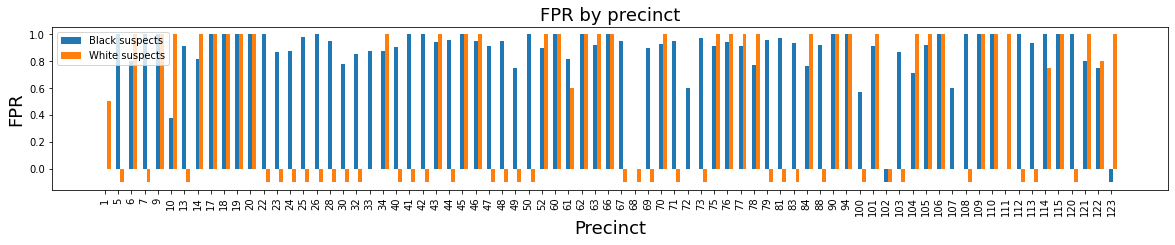

In [1098]:
plot_by_precinct(bl_fpr_by_precinct, wh_fpr_by_precinct, 'FPR by precinct', 'FPR')

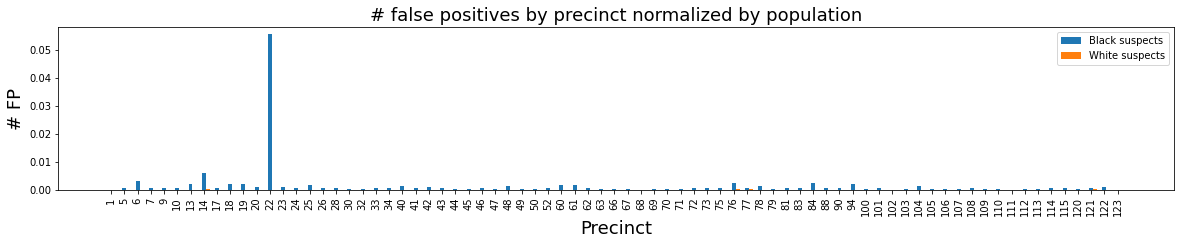

In [1099]:
plot_by_precinct(bl_fpcounts_by_precinct, wh_fpcounts_by_precinct, '# false positives by precinct normalized by population', '# FP')

In [1020]:
bl_fpcounts_by_precinct[12] 
# wh_fpcounts_by_precinct[12] 

0.05555555555555555

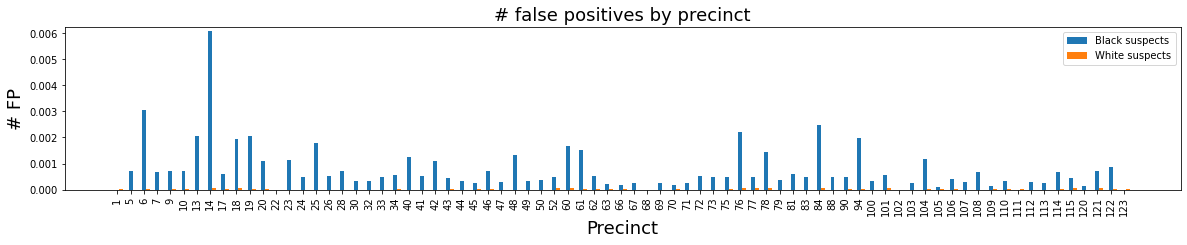

In [1002]:
plot_by_precinct(bl_fpcounts_by_precinct, wh_fpcounts_by_precinct, '# false positives by precinct', '# FP')

Next, we train a logistic regression classifier $\hat{f}$ on selected features $X$, which include attributes of the subject and circumstances of the stop in question. The target variable is $Y$. We first select the target variable and features of interest. 

We will use this classifier to obtain the implied decision thresholds of NYPD frisks and searches.

In [1100]:
target = ['WEAPON_FOUND_FLAG', 'FRISKED_FLAG', 'SEARCHED_FLAG']

In [1101]:
regressors = [
              'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG',
              'BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG',
              'SUSPECTS_ACTIONS_CASING_FLAG',
              'SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG',
              'SUSPECTS_ACTIONS_DECRIPTION_FLAG',
              'SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG',
              'SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG',
              'SUSPECTS_ACTIONS_LOOKOUT_FLAG',
              'SUSPECTS_ACTIONS_OTHER_FLAG',
              'SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG',
              'SEARCH_BASIS_ADMISSION_FLAG',
              'SEARCH_BASIS_CONSENT_FLAG',
              'SEARCH_BASIS_HARD_OBJECT_FLAG',
              'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG',
              'SEARCH_BASIS_OTHER_FLAG',
              'SEARCH_BASIS_OUTLINE_FLAG',
              'SUSPECT_REPORTED_AGE',
              'SUSPECT_SEX',                                                 
              'SUSPECT_RACE_DESCRIPTION',
              'STOP_LOCATION_PRECINCT'
             ]

Clean up and gather data. 

In [1102]:
#replace string values with integer flags
sqf2020.replace('Y',1,inplace=True)
sqf2020.replace('N',0,inplace=True)
sqf2020.replace('(null)',0,inplace=True)
sqf2020.replace('(', 0,inplace=True)

#gather dataframes
X = sqf2020[regressors]
Y = sqf2020[target]
#cast target variables into floats
Y = Y.astype(float)

#get dummy indicators for categorical variables
X = pd.get_dummies(X, prefix='SEX', prefix_sep='_', 
                            columns=['SUSPECT_SEX'])

X = pd.get_dummies(X, prefix='RACE', prefix_sep='_',
                           columns=['SUSPECT_RACE_DESCRIPTION'])

X = pd.get_dummies(X, prefix='PRECINCT', prefix_sep='_', columns=['STOP_LOCATION_PRECINCT'])

#cast features as float
X = X.astype(float)

#standardize features
scaler = StandardScaler()
X['SUSPECT_REPORTED_AGE'] = scaler.fit_transform(X['SUSPECT_REPORTED_AGE'][:,np.newaxis])

<ipython-input-1102-a681d61e555d>:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X['SUSPECT_REPORTED_AGE'] = scaler.fit_transform(X['SUSPECT_REPORTED_AGE'][:,np.newaxis])


Define logistic regression classifier and train using SGD.

In [1103]:
fhat = SGDClassifier(loss="log", penalty="l2", max_iter=100)
fhat.fit(X, np.ravel(Y['WEAPON_FOUND_FLAG']))

SGDClassifier(loss='log', max_iter=100)

Plot ROC curve for classifier, with NYPD FPR and TPR for comparison.

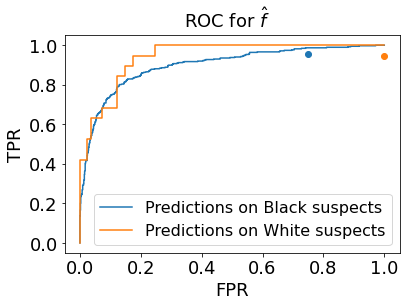

In [1104]:
fig = plot_roc_curve(fhat, X[X['RACE_BLACK']==1], Y[X['RACE_BLACK']==1]['WEAPON_FOUND_FLAG'])
fig2 = plot_roc_curve(fhat, X[X['RACE_WHITE']==1], Y[X['RACE_WHITE']==1]['WEAPON_FOUND_FLAG'],ax=fig.ax_)
fig.figure_.suptitle("ROC for $\hat{f}$", fontsize=18)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Predictions on Black suspects','Predictions on White suspects'],fontsize=16)
plt.scatter(bl_fpr,bl_tpr)
plt.scatter(wh_fpr,wh_tpr)

We define a "fair" classifier as one that equalizes the FPR for each individual group. Here, we identify the decision threshold for each group in $A$ that leads to fair classification. We set the desired FPR to .05. 

In [1141]:
def fpr_threshold(scores, fpr=wh_nypd_fpr):
    threshold_idx = len(scores)*(1-fpr)-1
    threshold_value = sorted(scores)[np.floor(threshold_idx).astype(int)]
    return threshold_value

We calculate these thresholds $\theta_A$using the probabilities of possession (scores) $\hat{R}$ output by $\hat{f}$ on the subset of data where $Y=0$ for each group $A$. 

In [1142]:
#scores for black suspects who don't have weapons
bl_rhat = clf.predict_proba(X[(X['RACE_BLACK']==1) & (Y['WEAPON_FOUND_FLAG']==0)])[:,0]

#theta for black suspects
bl_theta = fpr_threshold(bl_rhat)

#scores for white suspects who don't have weapons
wh_rhat = clf.predict_proba(X[(X['RACE_WHITE']==1) & (Y['WEAPON_FOUND_FLAG']==0)])[:,0]

#theta for white suspects
wh_theta = fpr_threshold(wh_rhat)

In [1143]:
print('Fair decision threshold on probability of weapon possession for black suspects: {}'.format(bl_theta))
print('Fair decision threshold on probability of weapon possession for white suspects: {}'.format(wh_theta))

Fair decision threshold on probability of weapon possession for black suspects: 0.9477519638244901
Fair decision threshold on probability of weapon possession for white suspects: 0.9687960332453079


Next, we compare these thresholds to the implied thresholds used by NYPD, using the FPRs for $\hat{Y}$.

In [1144]:
#implied theta for black suspects 
bl_yhat_theta = fpr_threshold(bl_rhat, fpr=bl_nypd_fpr)

#implied theta for white suspects
wh_yhat_theta = fpr_threshold(wh_rhat, fpr=wh_nypd_fpr)

In [1145]:
print('Implied threshold on probability of weapon possession for black suspects: {}'.format(bl_yhat_theta))
print('Implied threshold on probability of weapon possession for white suspects: {}'.format(wh_yhat_theta))

Implied threshold on probability of weapon possession for black suspects: 0.6597119033470517
Implied threshold on probability of weapon possession for white suspects: 0.8253796755058838


Finally, we look at how the classifier using the "fair" decision thresholds  performs within each precinct. We do this by counting the number of false positives incurred by the model using the within each precinct. 

In [1146]:
bl_fhat_fpcounts_by_precinct = []
bl_fhat_fpr_by_precinct = []
wh_fhat_fpcounts_by_precinct = []
wh_fhat_fpr_by_precinct = []
for idx, precinct in enumerate(np.sort(sqf2020['STOP_LOCATION_PRECINCT'].unique())):    
    #scores for black suspects with no weapon
    features = X[(X['RACE_BLACK']==1) 
                & (X['PRECINCT_{}'.format(precinct)]==1)
                & (Y['WEAPON_FOUND_FLAG']==0)
                ]
    if len(features) > 0:
        bl_all = census_precincts[census_precincts['precinct_2020']==precinct]['P0010004'].iat[0]
        bl_rhat = clf.predict_proba(features)[:,0]
        bl_fhat_fpcounts_by_precinct.append((((bl_rhat >=  bl_theta).astype(int)).sum())/bl_all)
        
        bl_fhat_fpr_by_precinct.append(len(bl_rhat[bl_rhat >= bl_theta])/len(bl_rhat))

        
    else:
        bl_fhat_fpcounts_by_precinct.append(0)
        bl_fhat_fpr_by_precinct.append(-.1)
    

    
    #scores for white suspects with no weapon
    
    features = X[(X['RACE_WHITE']==1) 
                 & (X['PRECINCT_{}'.format(precinct)]==1)
                 & (Y['WEAPON_FOUND_FLAG']==0)
                ]
    if len(features) > 0:
        wh_all = census_precincts[census_precincts['precinct_2020']==precinct]['P0010003'].iat[0]
        
        wh_rhat = clf.predict_proba(features)[:,0]
        wh_fhat_fpcounts_by_precinct.append((((wh_rhat >=  wh_theta).astype(int)).sum())/wh_all)
        wh_fhat_fpr_by_precinct.append(len(wh_rhat[wh_rhat >= wh_theta])/len(wh_rhat))
      
    else:
        wh_fhat_fpcounts_by_precinct.append(0)
        wh_fhat_fpr_by_precinct.append(-.1)

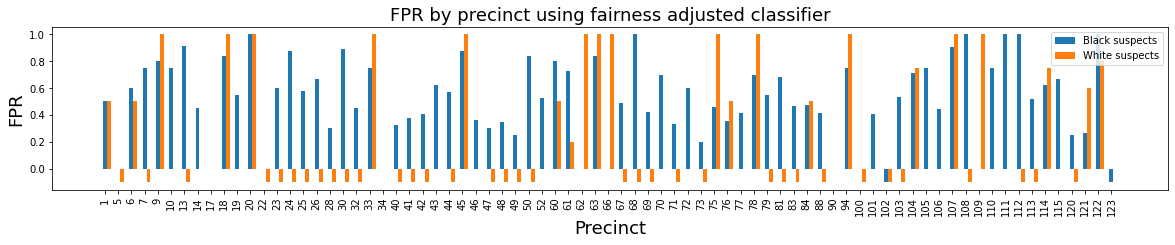

In [1147]:
plot_by_precinct(bl_fhat_fpr_by_precinct, wh_fhat_fpr_by_precinct, 'FPR by precinct using fairness adjusted classifier', 'FPR')

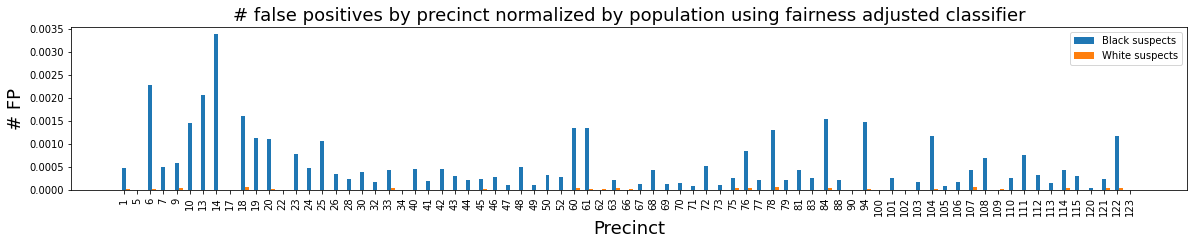

In [1148]:
fig = plot_by_precinct(bl_fhat_fpcounts_by_precinct, wh_fhat_fpcounts_by_precinct, '# false positives by precinct normalized by population using fairness adjusted classifier', '# FP')

In [1138]:
bl_fhat_fpcounts_by_precinct[12]
# wh_fhat_fpcounts_by_precinct[12]

0.05555555555555555

In [1139]:
bl_fhat_fpcounts_by_precinct[12] = 0

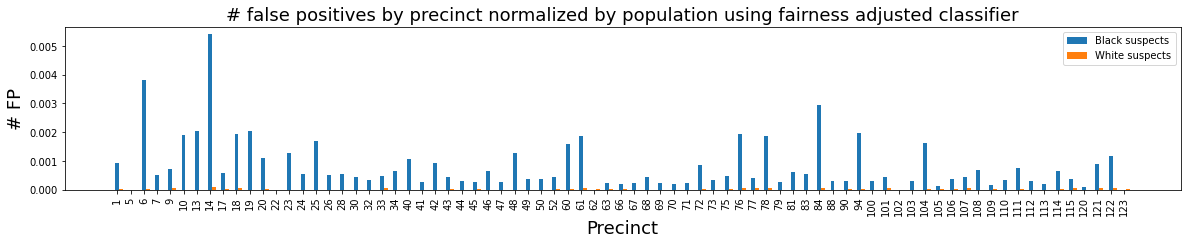

In [1140]:
fig = plot_by_precinct(bl_fhat_fpcounts_by_precinct, wh_fhat_fpcounts_by_precinct, '# false positives by precinct normalized by population using fairness adjusted classifier', '# FP')